In [185]:
import string
import csv
import datetime
from pprint import pprint

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns


import gensim
from gensim import corpora
import gensim, logging, warnings
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
from nltk import corpus
from nltk.corpus import stopwords

import spacy

## This is a software that uses LDA model from nltk library and creates a metric 


- How to run on Linux:
    - sudo pip install -U numpy
    - sudo pip install -U gensim
    - sudo pip install -U nltk
    - cd /usr/local/lib/python3.5/dist-packages
    - sudo python -m nltk.downloader stopwords
    - sudo python -m nltk.downloader wordnet
    
- Windows or MacOs:
    - pip install -U nltk
    - pip install -U numpy
    - pip install -U gensim
    - python
    <br>
    <font color=red>
    import nltk
    <br>
    nltk.download('stopwords')
    <br>
    nltk.download('wordnet')
    </font>

In [4]:
class Metrics:
    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    @staticmethod
    def weighted_mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs(((y_true*y_pred) - (y_pred*y_pred)) / (y_true* y_pred))) * 100

In [5]:
class Research:
    @staticmethod
    def parse_xls(xls_file=None):
        if not xls_file:
            return False
        df = pd.read_excel(xls_file)
        return list(df['Abstract Note'])

    @staticmethod
    def parse_scholar(query_word='security', size=6, initial_time=None, end_time=None):
        import scholarly
        q = '/scholar?lr=lang_us&q='+query_word+'&hl=en-US&as_vis=1&as_sdt=1,5'
        if(initial_time != None):
            q = q + '&as_ylo=' + initial_time
        if(end_time != None):
            q = q +'&as_yhi=' + end_time
        searchFilter = scholarly.search_pubs_custom_url(q)
        return [next(searchFilter).bib['abstract'] for i in range(size)]
    @staticmethod
    def words_stop(stopPath):
        stop_words = set(stopwords.words('english'))
        with open(stopPath, "rb") as msw:
            my_stops = msw.read().decode('utf-8').split("\r\n")            
            stop_words.extend(my_stops)
        return stop_words
    @staticmethod    
    def clean(doc, stopPath):
        exclude = set(string.punctuation)
        lemma = WordNetLemmatizer()          
        stop = set(stopwords.words('english'))      
        my_stops = Research.words_stop(stopPath)
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return " ".join([i for i in normalized.split() if i not in my_stops])
    @staticmethod
    def save(path, doc_list):
        with open(path, "wb") as file:
            doc_str = str(doc_list).encode("utf-8")
            file.write(doc_str)

In [6]:
class Cleaner:
    def __init__(self):
        self.result = []
    @staticmethod
    def clean_xls(xls_file_in=None, xls_file_out=None):
        if not xls_file_in:
            return False
        if not xls_file_out:
            xls_file_out = xls_file_in

        data = pd.read_excel(xls_file_in, index_col=0)
        data = clean_panda(data)
        data.to_excel(xls_file_out)
        
    @staticmethod
    def clean_csv(csv_file_in=None, csv_file_out=None):
        if not csv_file_in:
            return False
        if not csv_file_out:
            csv_file_out = csv_file_in

        data = pd.read_csv(csv_file_in, index_col=0)
        data = clean_panda(data)
        data.to_csv(csv_file_out)

    @staticmethod
    def clean_panda(data):
        data["abstract"] = data["abstract"].apply(lambda x: re.sub("([©]*)\.","",x))#remove copyright's
        data["abstract"] = data["abstract"].apply(lambda x: re.sub('\S*@\S*\s?', '', x))#remove emails
        data["abstract"] = data["abstract"].apply(lambda x: re.sub('\s+', ' ', x))#
        data["abstract"] = data["abstract"].apply(lambda x: re.sub("\'", ' ', x))# remove '
        return data

In [7]:
#Set variables
source = 'Papers.xlsx'
stopWords = 'BlockWords.txt'
clean_path = 'CleanArchive.txt'
log_path = 'BeforeArchive.txt'
topics = 10
words = 8

In [35]:
df_a = pd.read_excel(source)
df_a.head()

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,Programming Language,Version,System,Code,Code Number,Section,Session,Committee,History,Legislative Body
0,X7YSC7CJ,conferencePaper,2009,"Abawajy, Jemal H","""Design and Delivery of Undergraduate Informat...",ADVANCES IN InformationSecurity AND ASSURANCE,978-3-642-02616-4,NaN,"""10.1007/978-3-642-02617-1_41""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,THTF9GDG,conferencePaper,2008,"Kamel, M.; Laborde, R.; Benzekri, A.; Barrere, F.",A best practices-oriented approach for establi...,Proceedings - IEEE International Enterprise Di...,978-1-4244-4485-4,NaN,10.1109/EDOCW.2008.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9EJF8UK5,conferencePaper,2017,"Fangfang, Dang; Fajia, Ji; Lei, Zhu; Ying, Yang",A Brief Talk on InformationSecurity Basic Man...,Proceedings of the 2017 4Th International Conf...,978-94-6252-439-2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W3BP36PA,conferencePaper,2011,"Sadok, M.; Spagnoletti, P.",A business aware InformationSecurity risk ana...,Information Technology and Innovation Trends i...,978-3-7908-2631-9,NaN,10.1007/978-3-7908-2632-6_51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H74DE578,journalArticle,2015,"Ahmad, Atif; Maynard, Sean B.; Shanks, Graeme",A case analysis of information systems and sec...,International Journal of Information Management,NaN,02684012,10.1016/j.ijinfomgt.2015.08.001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_limpo = pd.concat([df_a['Key'], df_a['Item Type'], df_a['Publication Year'], df_a['Author'], df_a['Title'], df_a['ISBN'], df_a['Abstract Note']], axis=1)

In [37]:
df_limpo.head()

,Key,Item Type,Publication Year,Author,Title,ISBN,Abstract Note
0,X7YSC7CJ,conferencePaper,2009,"Abawajy, Jemal H","""Design and Delivery of Undergraduate Informat...",978-3-642-02616-4,Information technology has become the core too...
1,THTF9GDG,conferencePaper,2008,"Kamel, M.; Laborde, R.; Benzekri, A.; Barrere, F.",A best practices-oriented approach for establi...,978-1-4244-4485-4,Within a Virtual Organisation collaborative en...
2,9EJF8UK5,conferencePaper,2017,"Fangfang, Dang; Fajia, Ji; Lei, Zhu; Ying, Yang",A Brief Talk on InformationSecurity Basic Man...,978-94-6252-439-2,With the rapid development of the intelligent ...
3,W3BP36PA,conferencePaper,2011,"Sadok, M.; Spagnoletti, P.",A business aware InformationSecurity risk ana...,978-3-7908-2631-9,Understanding the molecular mechanisms that sh...
4,H74DE578,journalArticle,2015,"Ahmad, Atif; Maynard, Sean B.; Shanks, Graeme",A case analysis of information systems and sec...,NaN,Our case analysis presents and identifies sign...


In [38]:
df = df_limpo['Abstract Note']

In [39]:
stop_words = stopwords.words('english')
with open(stopWords, "rb") as msw:
            my_stops = msw.read().decode('utf-8').split("\r\n")            
            stop_words.extend(my_stops)
            
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [40]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['information', 'technology', 'has', 'become', 'the', 'core', 'tool', 'of', 'business', 'organisations', 'external', 'and', 'internal', 'threats', 'as', 'well', 'as', 'legal', 'regulatory', 'and', 'contractual', 'compliance', 'requirements', 'are', 'all', 'combining', 'to', 'make', 'effective', 'key', 'management', 'challenges', 'this', 'paper', 'describes', 'an', 'undergraduate', 'security', 'management', 'course', 'that', 'provides', 'comprehensive', 'knowledge', 'and', 'skills', 'necessary', 'to', 'manage', 'both', 'strategic', 'and', 'operational', 'aspects', 'of', 'the', 'course', 'covers', 'broad', 'range', 'of', 'managerial', 'topics', 'in', 'security', 'and', 'makes', 'use', 'of', 'number', 'of', 'security', 'tools', 'and', 'techniques', 'to', 'complement', 'the', 'theory', 'taught', 'in', 'this', 'paper', 'we', 'describe', 'our', 'approach', 'our', 'experiences', 'and', 'lessons', 'learned', 'for', 'teaching', 'security', 'management', 'course', 'the', 'paper', 'details', 'th

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [42]:
data_ready[:1]

[['information',
  'technology',
  'become',
  'core',
  'tool',
  'business',
  'organisation',
  'external',
  'internal',
  'threat',
  'well',
  'legal',
  'regulatory',
  'contractual',
  'compliance',
  'requirement',
  'combine',
  'make',
  'effective',
  'key',
  'management',
  'challenge',
  'paper',
  'describe',
  'undergraduate',
  'security',
  'management',
  'course',
  'provide',
  'comprehensive',
  'knowledge',
  'skill',
  'necessary',
  'manage',
  'strategic',
  'operational',
  'aspect',
  'course',
  'cover',
  'broad',
  'range',
  'managerial',
  'topic',
  'security',
  'make',
  'use',
  'number',
  'security',
  'tool',
  'technique',
  'complement',
  'theory',
  'teach',
  'paper',
  'describe',
  'approach',
  'experience',
  'lessons_learned',
  'teaching',
  'security',
  'management',
  'course',
  'paper',
  'detail',
  'content',
  'course',
  'outline',
  'teach',
  'assess']]

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           chunksize=500,
                                           passes=2,
                                           iterations=100)

pprint(lda_model.print_topics())

[(0,
  '0.028*"banking" + 0.017*"discrimination" + 0.014*"prudential" + '
  '0.014*"bank" + 0.013*"variation" + 0.011*"phenomenon" + 0.011*"shock" + '
  '0.009*"presence" + 0.008*"normal" + 0.008*"study"'),
 (1,
  '0.028*"security" + 0.022*"system" + 0.020*"information" + '
  '0.018*"management" + 0.009*"ism" + 0.008*"network" + 0.008*"base" + '
  '0.007*"control" + 0.007*"use" + 0.006*"paper"'),
 (2,
  '0.022*"security" + 0.019*"model" + 0.017*"employee" + 0.016*"study" + '
  '0.014*"research" + 0.012*"ism" + 0.012*"compliance" + 0.011*"organization" '
  '+ 0.010*"threat" + 0.010*"issue"'),
 (3,
  '0.058*"ism" + 0.016*"process" + 0.013*"paper" + 0.013*"certification" + '
  '0.012*"present" + 0.012*"standard" + 0.011*"implementation" + '
  '0.011*"organization" + 0.010*"analysis" + 0.010*"awareness"'),
 (4,
  '0.026*"ism" + 0.014*"enterprise" + 0.013*"process" + 0.012*"security" + '
  '0.011*"management" + 0.011*"use" + 0.010*"model" + 0.010*"base" + '
  '0.009*"risk" + 0.009*"approach

In [49]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.4236,"ism, organization, security, standard, informa...","[information, technology, become, core, tool, ..."
1,1,1.0,0.7345,"security, system, information, management, ism...","[virtual, organisation, collaborative, environ..."
2,2,1.0,0.5085,"security, system, information, management, ism...","[rapid, development, intelligent, electric, gr..."
3,3,1.0,0.8166,"security, system, information, management, ism...","[understand, molecular, mechanism, shape, effe..."
4,4,4.0,0.5159,"ism, enterprise, process, security, management...","[case, analysis, present, identifie, significa..."
5,5,1.0,0.9847,"security, system, information, management, ism...","[inadvertent, leakage, sensitive, information,..."
6,6,4.0,0.6032,"ism, enterprise, process, security, management...","[base, case, construct, system, inorganic, mat..."
7,7,1.0,0.8915,"security, system, information, management, ism...","[issue, event, order, distribute, system, cruc..."
8,8,7.0,0.5576,"ism, organization, security, standard, informa...","[business, use, internet, expose, security, ke..."
9,9,4.0,0.4760,"ism, enterprise, process, security, management...","[today, many, organization, quote, intent, cer..."


In [50]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9918,"banking, discrimination, prudential, bank, variation, phenomenon, shock, presence, normal, study","[statistical, analysis, variation, dayly, mean, frequency, maximum, ionospheric, electron, densi..."
1,1.0,0.9954,"security, system, information, management, ism, network, base, control, use, paper","[context, paper, urgent, problem, development, software, decision_make, support, system, solve, ..."
2,2.0,0.9951,"security, model, employee, study, research, ism, compliance, organization, threat, issue","[many, organization, recognize, employee, often, consider, weakest_link, also, great, asset, eff..."
3,3.0,0.9929,"ism, process, paper, certification, present, standard, implementation, organization, analysis, a...","[ism, play, important, role, help, organization, manage, information, securely, however, establi..."
4,4.0,0.9941,"ism, enterprise, process, security, management, use, model, base, risk, approach","[optimise, way, question, check, list, offer, great, potential, improve, quality, risk, assessme..."
5,5.0,0.8582,"protection, fmri, security, instantaneous, limit, iso, value_conflict, level, audits, study","[paper, look, experience, various, asian, country, expand, coverage, pension, system, informal, ..."
6,6.0,0.9866,"management, risk, skill, research, process, ism, standard, use, study, backslash","[design, case, focus, redesign, advanced, instructional, design, capstone, course, teach, midwes..."
7,7.0,0.9944,"ism, organization, security, standard, information, management, study, risk, use, paper","[business, leader, shall, responsibility, cope, managerial, branch, knowledge, discipline, requi..."
8,8.0,0.9938,"management, model, wiki, process, ism, private, system, resilience, study, use","[background, detection, bone_marrow, involvement, use, fluoro, deoxy, glucose, positron, emissio..."
9,9.0,0.9836,"risk, management, fisma, standard, system, nist, federal, conference, industrial, guideline","[gestion, controle, informacion, proceso, facil, debe, ajustar, las, caracteristicas, propia, or..."


In [63]:
df_dominant_topic.describe()

,Document_No,Dominant_Topic,Topic_Perc_Contrib
count,604.000000,604.000000,604.000000
mean,301.500000,3.610927,0.700302
std,174.504059,2.689445,0.201547
min,0.000000,0.000000,0.283000
25%,150.750000,1.000000,0.519800
50%,301.500000,3.000000,0.693750
75%,452.250000,7.000000,0.893925
max,603.000000,9.000000,0.995400


In [182]:
#prepare docs
#log = research.revoke(source)
doc_complete = Research.parse_xls(source)
doc_clean = [Research.clean(doc, stopWords).split() for doc in doc_complete]


NameError: name 'WordNetLemmatizer' is not defined

In [ ]:
#save this version and alterations
Research.save(log_path, []) #log)
Research.save(clean_path, doc_clean)

In [183]:
#dictionary and matrix
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

NameError: name 'doc_clean' is not defined

In [10]:
#lda model
LDA = gensim.models.ldamodel.LdaModel

In [11]:
#LDA result
result = LDA(doc_term_matrix, num_topics=topics, id2word=dictionary, passes=2)

## Metrics works

In [181]:
table = result.show_topics(formatted=False)

NameError: name 'result' is not defined

In [88]:
real = [0.0122 for x in range(100)]

In [180]:
predict = []
for x in range(10):
    for y in range(10):
        predict.append(table[x][1][y][1])
predict[:6]

NameError: name 'table' is not defined

In [13]:
print(Metrics.mean_absolute_percentage_error(real,predict))
print(Metrics.weighted_mean_absolute_percentage_error(real,predict))

32.99258541315794
32.99258555380613


In [187]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [193]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

corpus = [id2word.doc2bow(text) for text in data_ready]
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.48742958554589

Coherence Score:  0.3472489906800987


# Graphic Runs

In [139]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

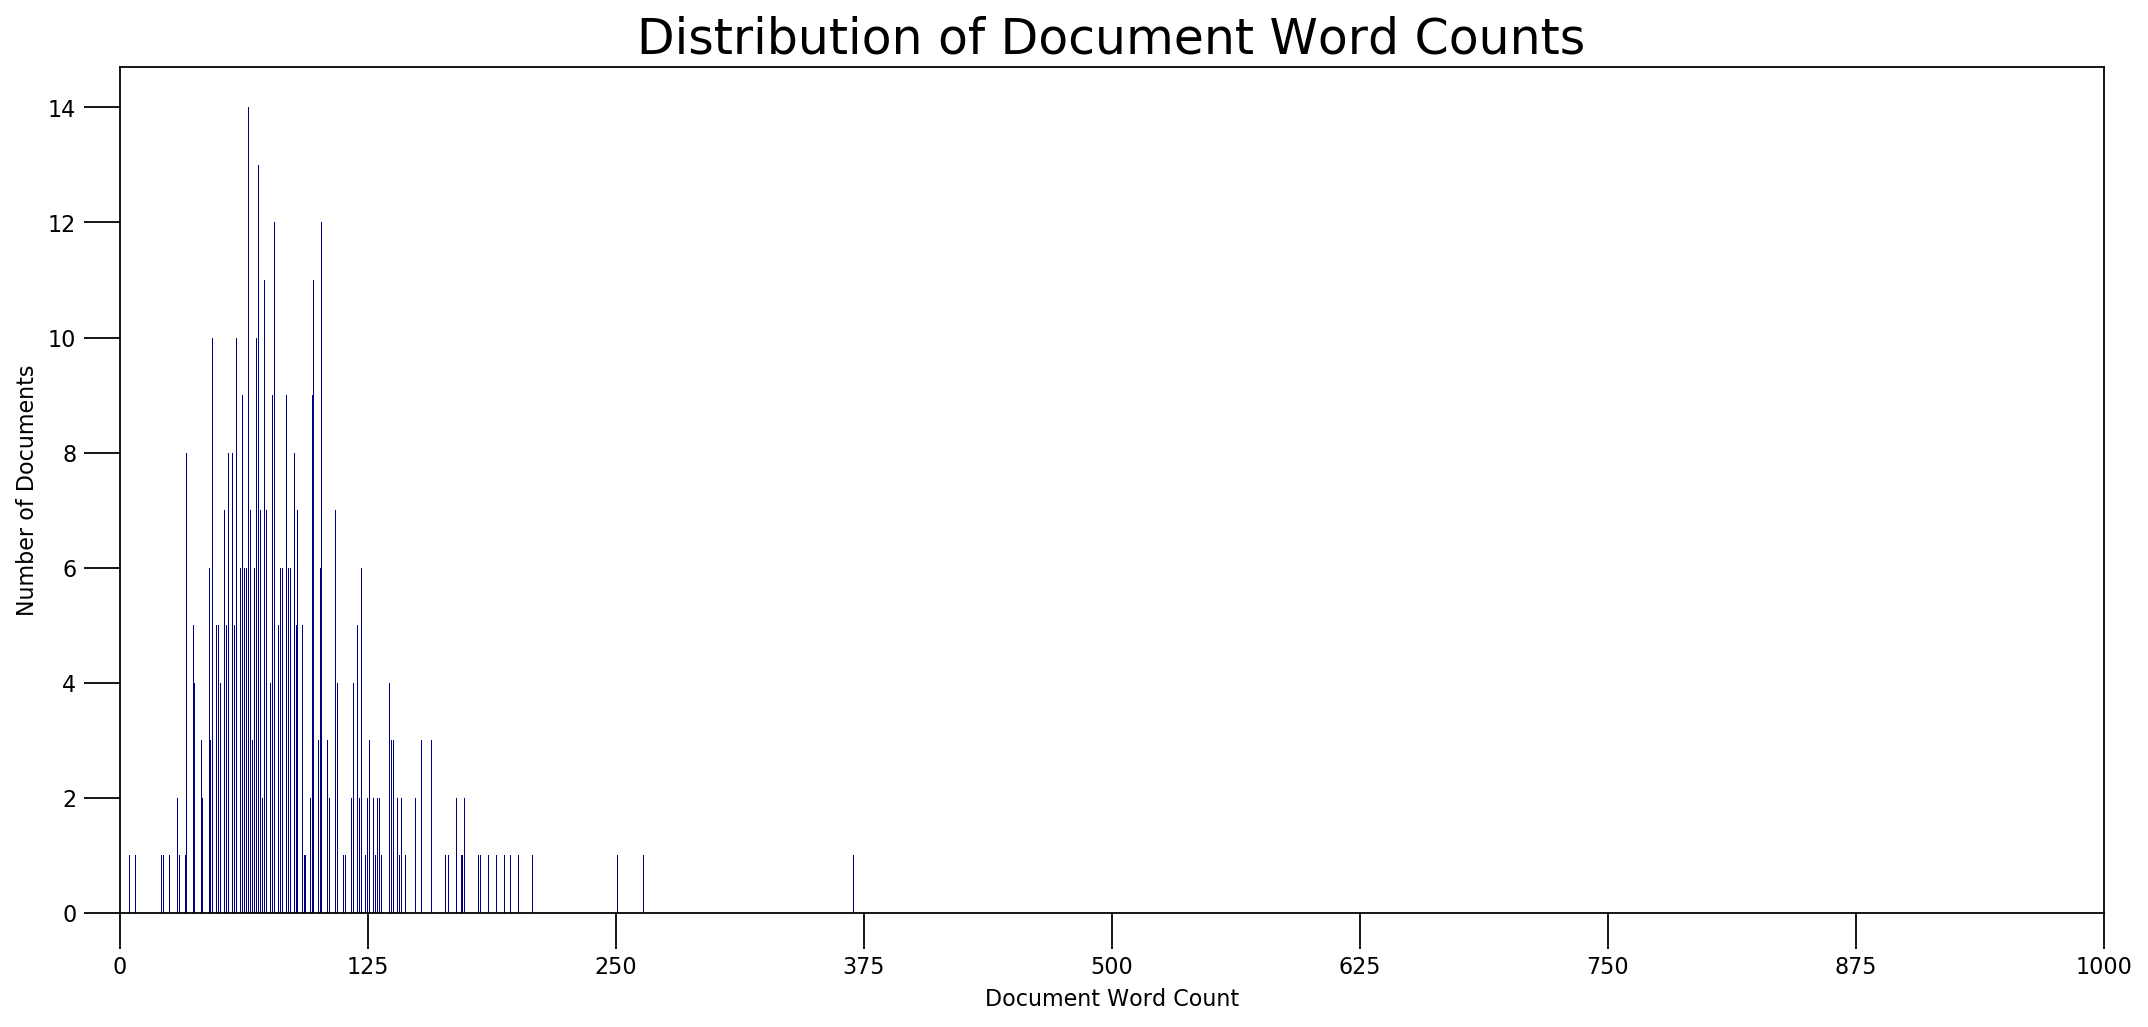

In [54]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [58]:

print("Mean   : " + str(round(np.mean(doc_lens))))
print("Median : " + str(round(np.median(doc_lens))))
print("Stdev   : " + str(round(np.std(doc_lens))))
print("1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
print("99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

Mean   : 86.0
Median : 78.0
Stdev   : 39.0
1%ile    : 24.0
99%ile  : 206.0


In [74]:
data_to_list = sum(data_words, [])
freq_init = nltk.FreqDist(data_to_list)

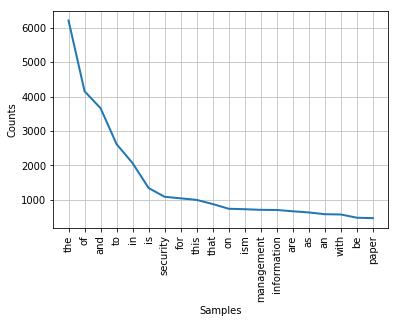

89155

In [76]:
freq_init.plot(20, cumulative=False)
len(data_to_list)

In [78]:
data_ready_to_list = sum(data_ready, [])
freq_final = nltk.FreqDist(data_ready_to_list)

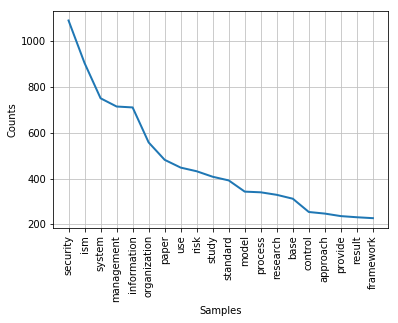

51892

In [79]:
freq_final.plot(20, cumulative=False)
len(data_ready_to_list)

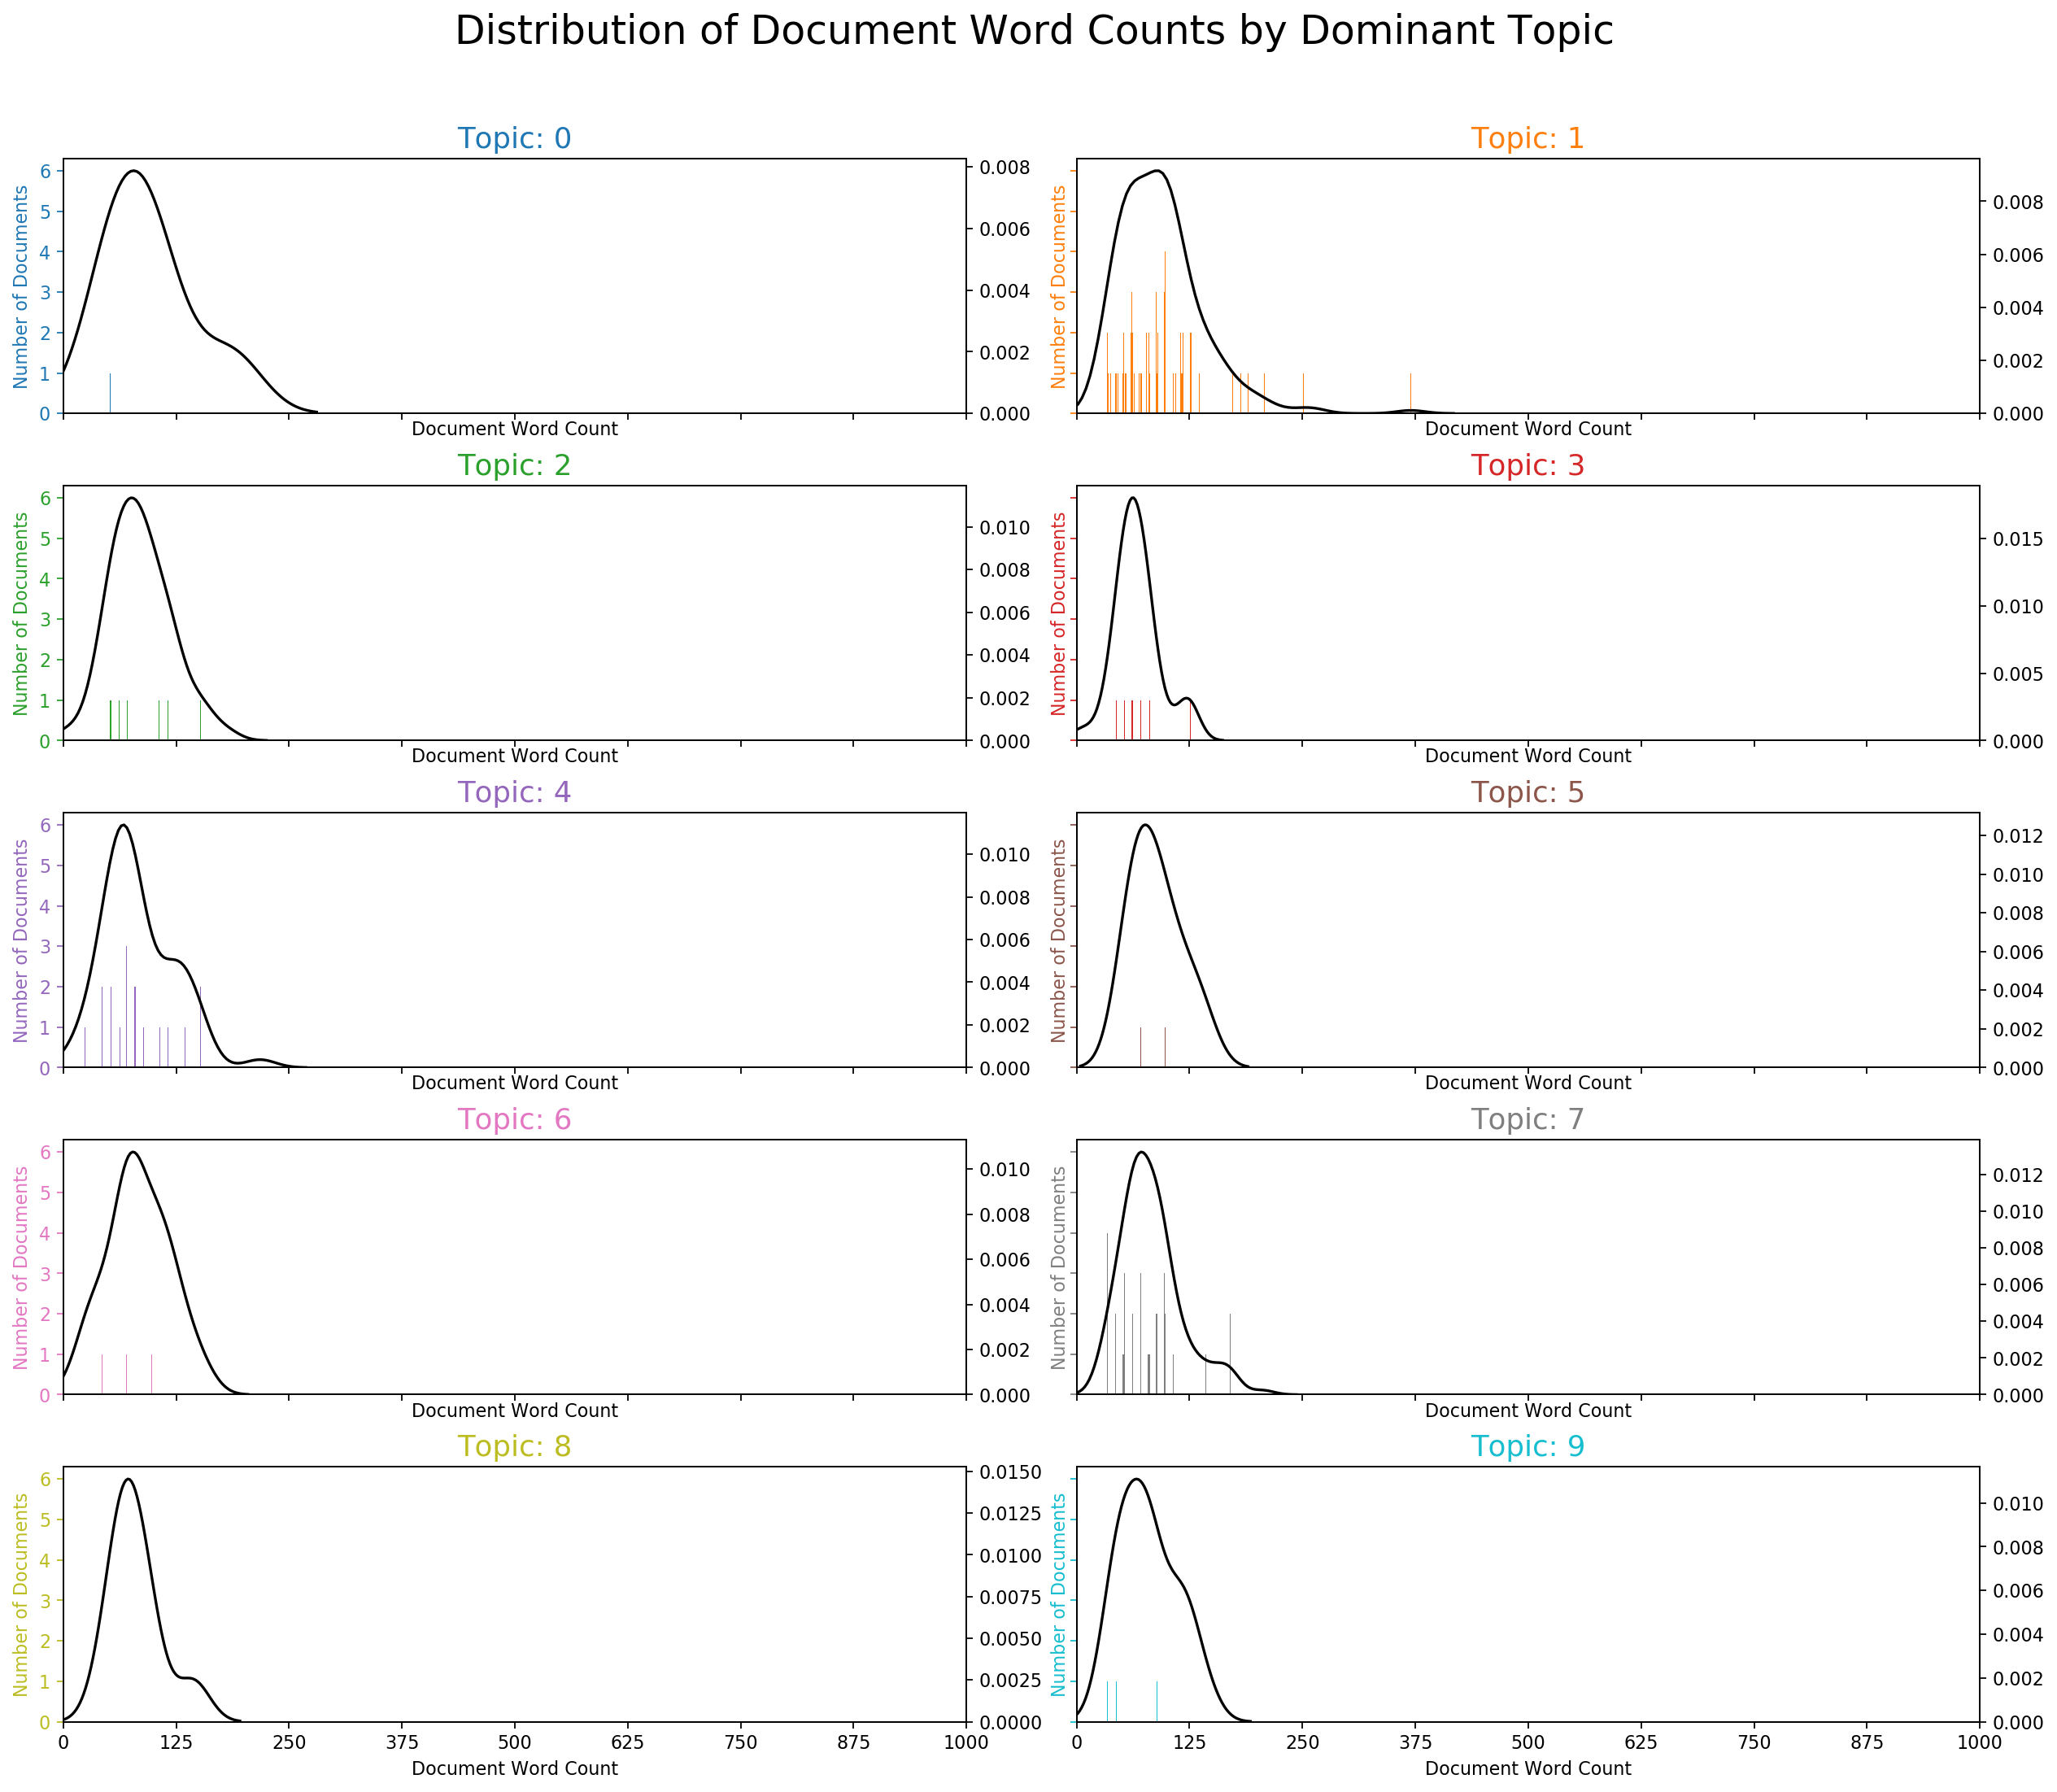

In [102]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

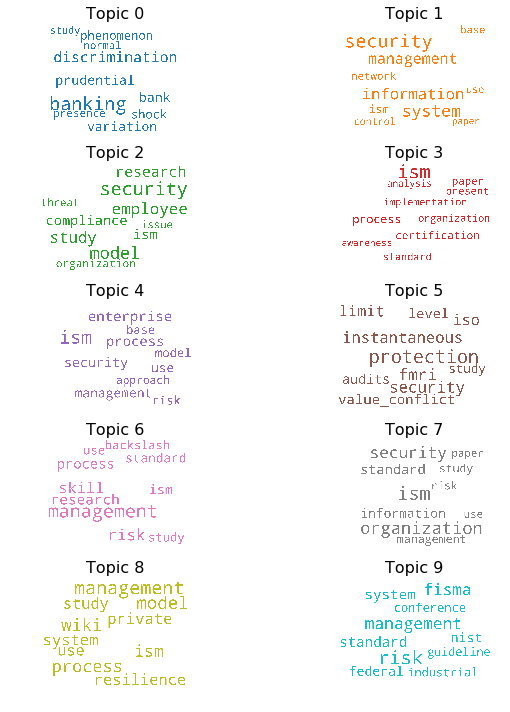

In [87]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

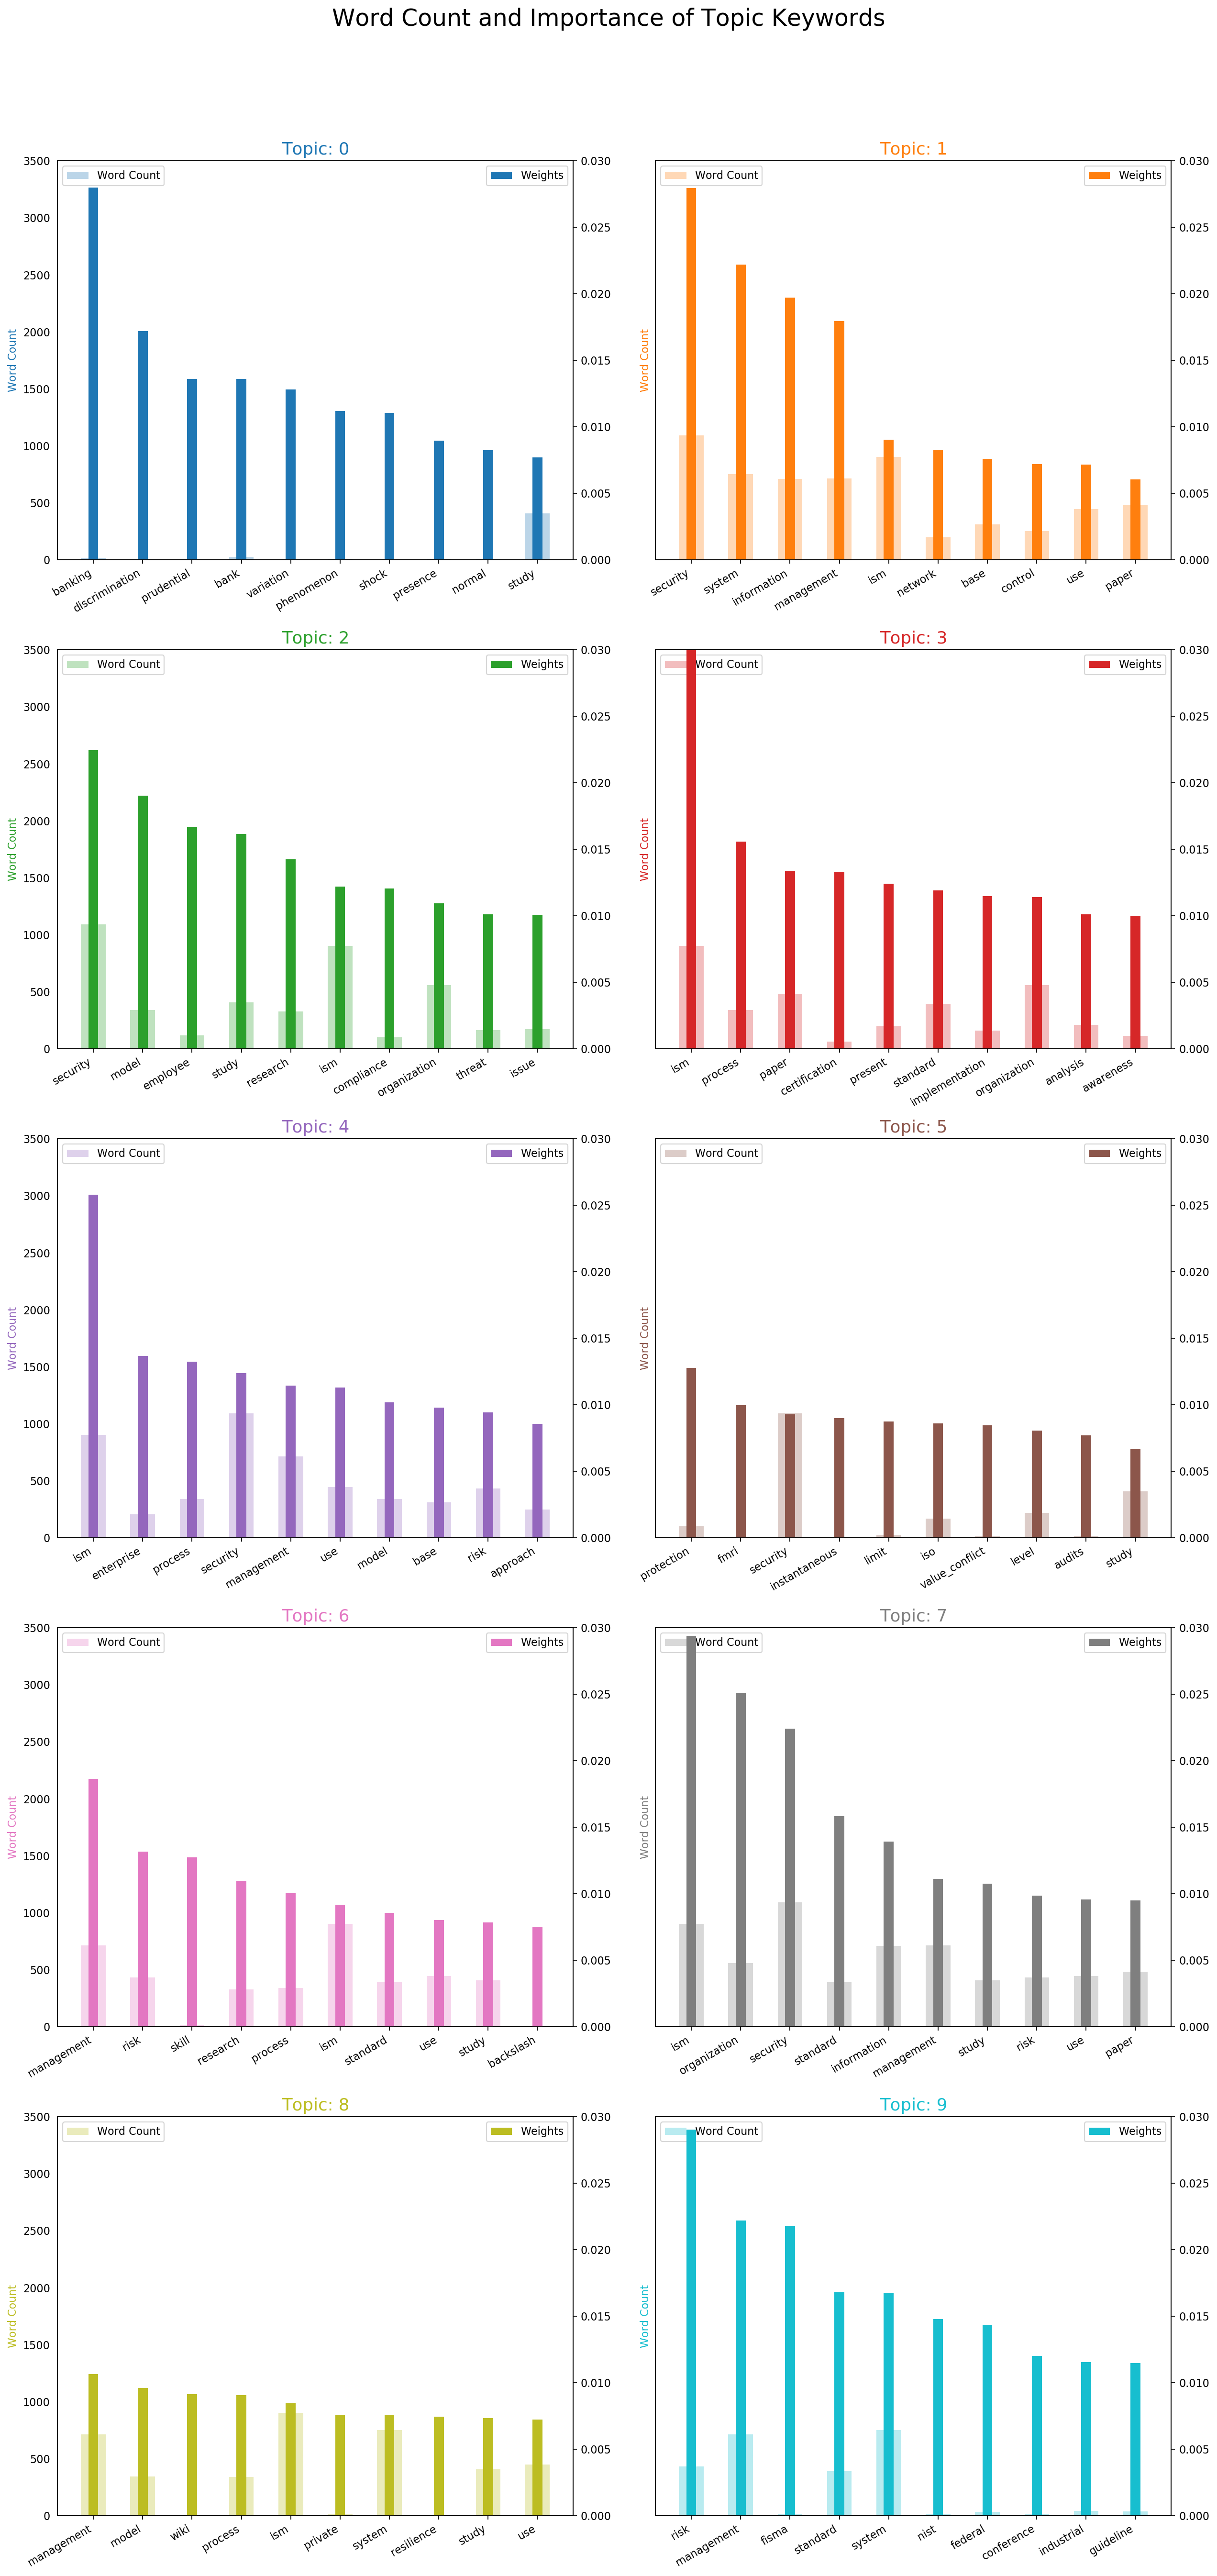

In [94]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,32), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [175]:
# Build LDA model
lda_model_g = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model_g.print_topics())

[(0,
  '0.049*"security" + 0.015*"organization" + 0.013*"model" + 0.011*"paper" + '
  '0.010*"research" + 0.010*"information" + 0.009*"compliance" + '
  '0.009*"network" + 0.009*"approach" + 0.009*"use"'),
 (1,
  '0.022*"firm" + 0.019*"detection" + 0.017*"advice" + 0.016*"hacker" + '
  '0.012*"event" + 0.012*"discrimination" + 0.010*"sharing" + 0.009*"work" + '
  '0.009*"engineering" + 0.009*"patch"'),
 (2,
  '0.053*"system" + 0.042*"management" + 0.038*"ism" + 0.022*"study" + '
  '0.021*"risk" + 0.020*"information" + 0.019*"standard" + 0.017*"process" + '
  '0.016*"control" + 0.012*"method"'),
 (3,
  '0.076*"employee" + 0.012*"medical" + 0.012*"trust" + 0.011*"workplace" + '
  '0.011*"visibility" + 0.011*"impediment" + 0.010*"conference" + '
  '0.010*"digital" + 0.009*"privacy" + 0.009*"cloud"')]


In [176]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model_g, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model_g.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

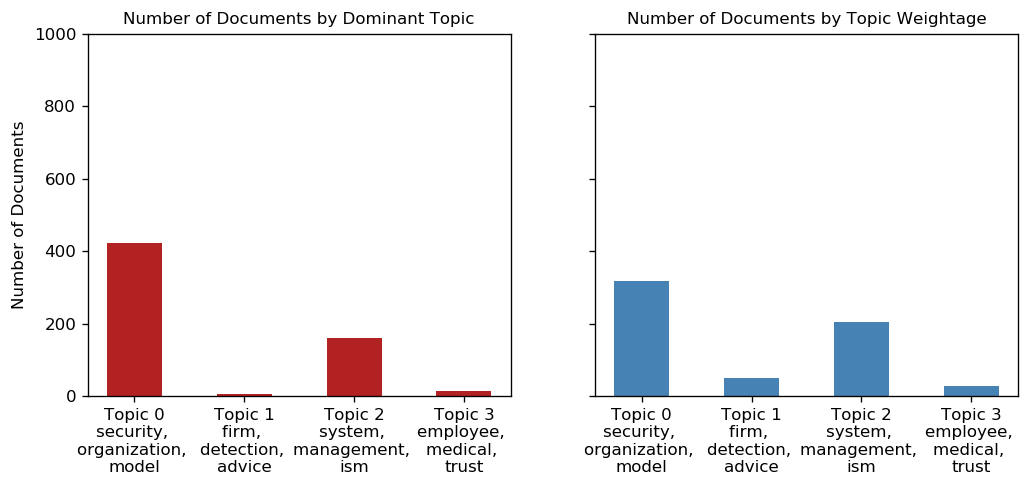

In [177]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

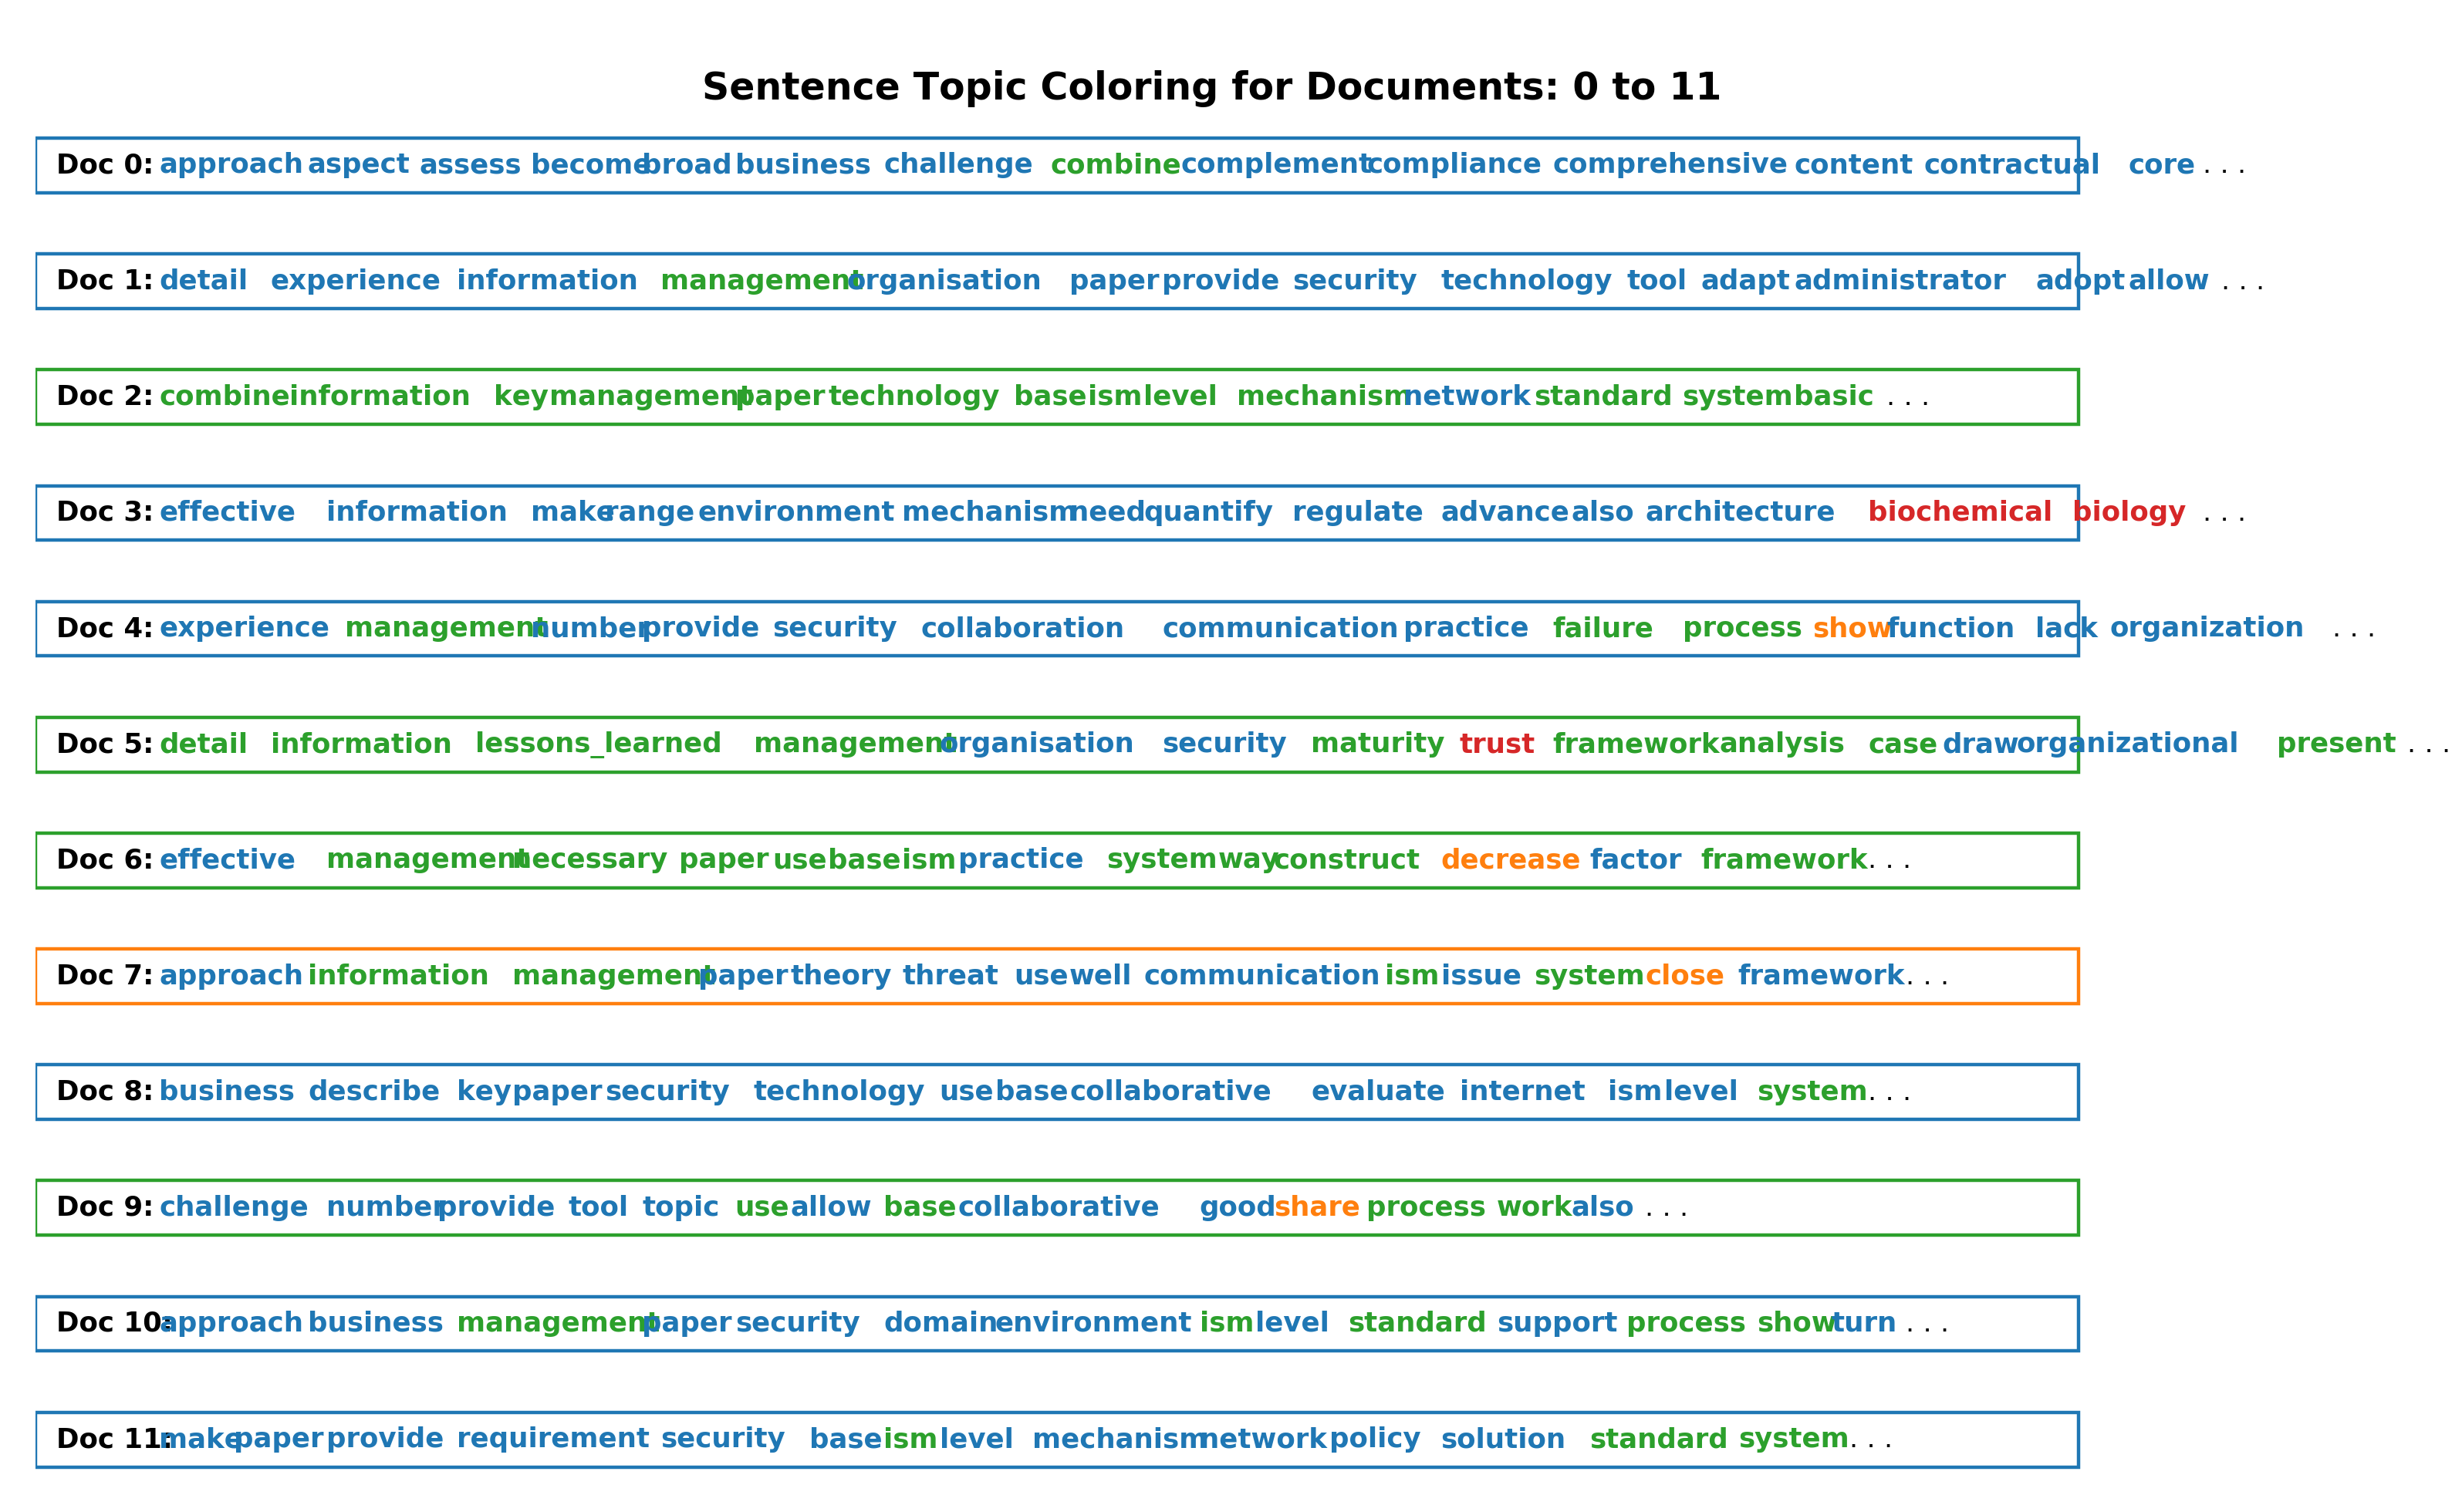

In [178]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model_g, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [155]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 594 samples in 0.134s...
[t-SNE] Computed neighbors for 594 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 594 / 594
[t-SNE] Mean sigma: 0.004731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.096626
[t-SNE] KL divergence after 1000 iterations: 0.295072


Loading BokehJS ...